# Part 0: Data Analysis & Preprocessing

In [1]:
import sklearn
import pandas as pd
import logging
import numpy as np
import sklearn.model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, loguniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
sklearn.random.seed(12345)

In [2]:
data_matrix = pd.read_csv("data.csv")
print("Import of Predictor Variables Successful")

# Transform Target Matrix
target_matrix = pd.read_csv("flowering_time.csv", header = None)
target_matrix = (target_matrix>40).astype(int)
print("Binary Target Variable created")

Import of Predictor Variables Successful
Binary Target Variable created


In [3]:
target_matrix.value_counts()

0
0    437
1    260
Name: count, dtype: int64

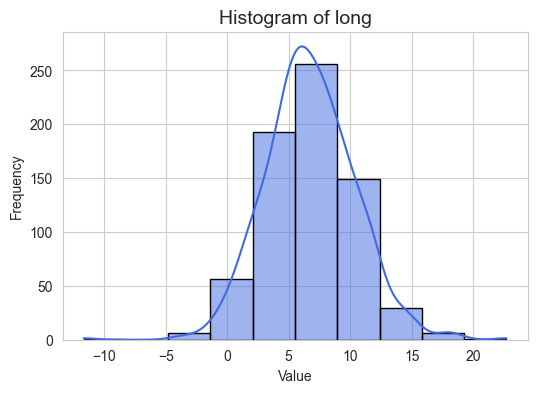

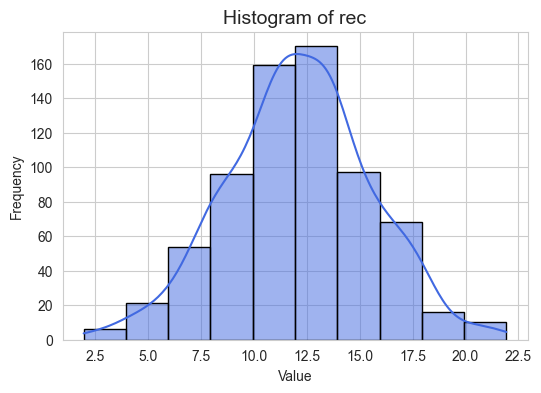

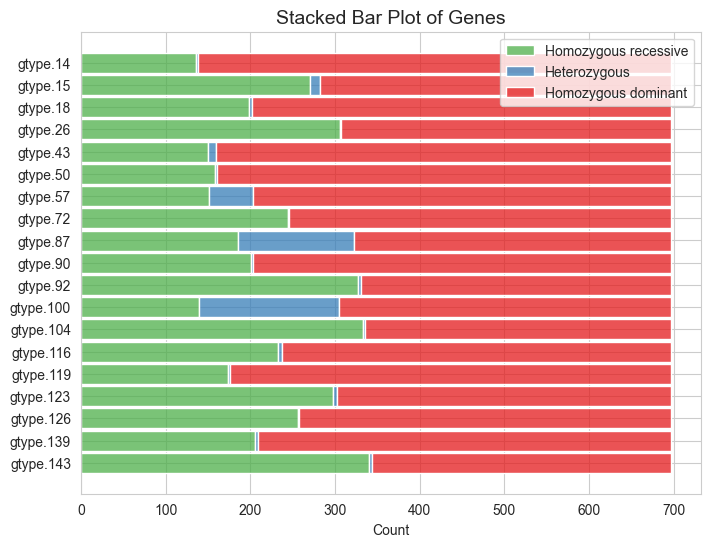

In [4]:
sns.set_style("whitegrid")

# Continuous variables
hist_vars = ["long", "rec"]

num_cols = data_matrix.select_dtypes(include=['number']).columns
categorical_vars = [col for col in num_cols if col not in hist_vars]

for col in hist_vars:
    plt.figure(figsize=(6, 4)) 
    sns.histplot(data_matrix[col], kde=True, bins=10, color="royalblue", edgecolor="black")
    plt.title(f'Histogram of {col}', fontsize=14)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

# Categorical variables
data_melted = data_matrix[categorical_vars].melt(var_name="Variable", value_name="Category")

plt.figure(figsize=(8, 6))
sns.histplot(data=data_melted, y="Variable", hue="Category", multiple="stack", shrink=0.9, palette="Set1")
plt.title("Stacked Bar Plot of Genes", fontsize=14)
plt.xlabel("Count")
plt.ylabel("")
plt.legend(["Homozygous recessive", "Heterozygous", "Homozygous dominant"])
plt.show()

There seems to be samples with negative lengths of plants. Since this is not feasible, we will remove these rows, before continuin with out preprocessing

In [5]:
print("Length before removing invalid rows: ", len(data_matrix))
data_matrix = data_matrix[data_matrix["long"]>=0]
target_matrix = target_matrix.iloc[data_matrix.index]
print("Length after removing invalid rows: ", len(data_matrix))

Length before removing invalid rows:  697
Length after removing invalid rows:  680


### Step 0: Preprocessing and Random Sampling

In [6]:
np.random.seed(12345)

# First, randomly generate indexes of selected rows (600 in Total)
indexes = np.random.randint(low = 0, high = len(target_matrix)-1, size = 600).tolist()
print("Random Indexes generated")

sampled_predictors = data_matrix.iloc[indexes,:]
sampled_targets = target_matrix.iloc[indexes,:]
print("Random Rows Selected based on generated indexes\n")


# Distinction between categorical and non-categorical variables for subsequent one-hot encoding. Additionally standard scaling of continuous
categorical_columns = [categorical for categorical in list(sampled_predictors.columns) if categorical[0] == "g"]
print("The categorical columns are: ", categorical_columns, "\n")

continuous_columns = [categorical for categorical in list(sampled_predictors.columns) if categorical[0] != "g"]
print("The continuous variables are: ", continuous_columns, "\n")

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('cont', StandardScaler(), continuous_columns)
    ])

sampled_predictors = preprocessor.fit_transform(sampled_predictors)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    sampled_predictors,
    sampled_targets,
    train_size = 2/3,
    random_state = 12345)


print("Train Test Split created")

Random Indexes generated
Random Rows Selected based on generated indexes

The categorical columns are:  ['gtype.14', 'gtype.15', 'gtype.18', 'gtype.26', 'gtype.43', 'gtype.50', 'gtype.57', 'gtype.72', 'gtype.87', 'gtype.90', 'gtype.92', 'gtype.100', 'gtype.104', 'gtype.116', 'gtype.119', 'gtype.123', 'gtype.126', 'gtype.139', 'gtype.143'] 

The continuous variables are:  ['long', 'rec'] 

Train Test Split created


# Part 1: Fit Base Models

## Model Nr. 1: Basic Decision Tree Classifier

In [7]:
basicTreeClassifier = DecisionTreeClassifier(random_state=12345)

basicTreeClassifier.fit(X=X_train, y=Y_train)

predictions_tree = basicTreeClassifier.predict(X_test)

In [8]:
print(basicTreeClassifier.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 12345, 'splitter': 'best'}


## Model Nr 2: Random Forest

In [9]:
randomForest = RandomForestClassifier(random_state=12345)

randomForest.fit(X_train, Y_train.to_numpy().ravel())

predictions_randomforest = randomForest.predict(X_test)

In [10]:
print(randomForest.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}


## Model 3: XGBosst with adjusted Parameters

In [11]:
XGTree = xgboost.XGBClassifier(random_state = 12345)

XGTree.fit(X_train, Y_train)
predictions_xgboost = XGTree.predict(X_test)

In [12]:
print(XGTree.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 12345, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


## Model 4: Standard Logistic Regression

In [13]:
logModel = LogisticRegression(random_state=12345)
logModel.fit(X_train, Y_train.to_numpy().ravel())

predictions_logreg = logModel.predict(X_test)

In [14]:
print(logModel.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Benchmark: No Information Rate

In [15]:
most_frequent_class = Counter(Y_train).most_common(1)[0][0]
predictions_naive = [most_frequent_class] * len(Y_test)


# Part 2: Base Model Evaluation

## Model Evaluation

Key Points:
- Evaluate model performance using a confusion matrix.
- Calculate performance metrics including:
    -  Accuracy, Sensitivity, Specificity, and F1-score.
    -  Compare models using ROC curves

### Evaluation 1: Basic Decision Tree Classifier

Confusion Matrix:
[[98 19]
 [19 64]]
Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       117
           1       0.77      0.77      0.77        83

    accuracy                           0.81       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.81      0.81      0.81       200



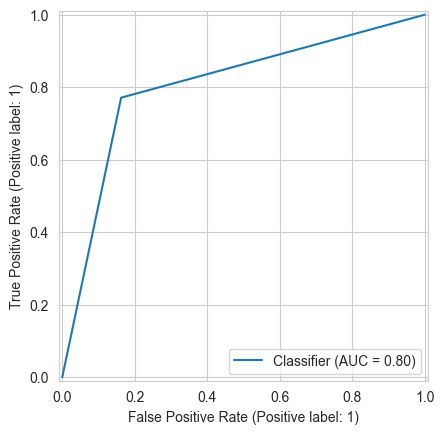

In [16]:
confusion_tree = confusion_matrix(Y_test, predictions_tree)
report_tree = classification_report(Y_test, predictions_tree)
accuracy_tree = accuracy_score(Y_test, predictions_tree)

print(f"Confusion Matrix:\n{confusion_tree}")
print(f"Accuracy: {accuracy_tree:.2f}")
print(f"Classification Report:\n{report_tree}")

ROCBDT = RocCurveDisplay.from_predictions(Y_test, predictions_tree)

As we can see, we have an AUC of around 0.66, which is okay, but not great.
The accuracy of 0.69 is mainly due to 37 samples being predicted as 0 although they are indeed 1, which leads our specificity for class 1 to being only 0.54 ...

### Evaluation 2: Random Forest

Accuracy: 0.90


Confusion Matrix:
[[112   5]
 [ 16  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.91       117
           1       0.93      0.81      0.86        83

    accuracy                           0.90       200
   macro avg       0.90      0.88      0.89       200
weighted avg       0.90      0.90      0.89       200



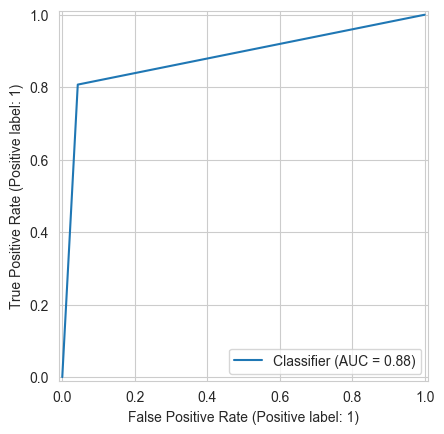

In [17]:
accuracy_randomforest = accuracy_score(Y_test, predictions_randomforest)
confusion_randomforest = confusion_matrix(Y_test, predictions_randomforest)
report_randomforest = classification_report(Y_test, predictions_randomforest)

print(f"Accuracy: {accuracy_randomforest:.2f}")
print(f"Confusion Matrix:\n{confusion_randomforest}")
print(f"Classification Report:\n{report_randomforest}")

ROCBRF = RocCurveDisplay.from_predictions(Y_test, predictions_randomforest)

Description of results here

### Evaluation 3: XGBoost

Accuracy: 0.91
Confusion Matrix:
[[109   8]
 [ 11  72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       117
           1       0.90      0.87      0.88        83

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.91      0.90       200



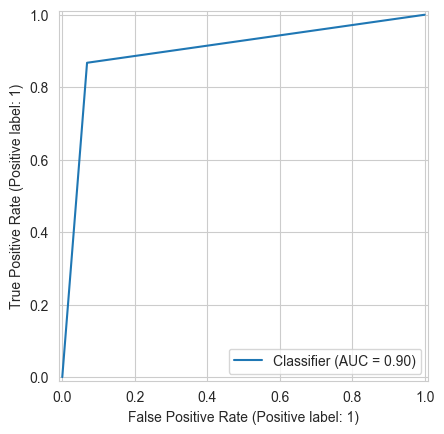

In [18]:
accuracy_xgboost = accuracy_score(Y_test, predictions_xgboost)
confusion_xgboost = confusion_matrix(Y_test, predictions_xgboost)
report_xgboost = classification_report(Y_test, predictions_xgboost)

print(f"Accuracy: {accuracy_xgboost:.2f}")
print(f"Confusion Matrix:\n{confusion_xgboost}")
print(f"Classification Report:\n{report_xgboost}")

ROCBXGB = RocCurveDisplay.from_predictions(Y_test, predictions_xgboost)

### Evaluation 4: Binary Logistic Regression

Accuracy: 0.86
Confusion Matrix:
[[105  12]
 [ 16  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       117
           1       0.85      0.81      0.83        83

    accuracy                           0.86       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.86      0.86       200



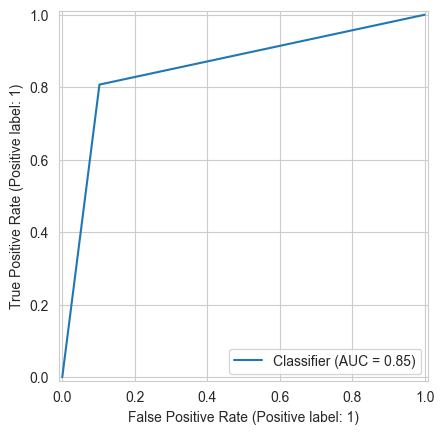

In [19]:
accuracy_logreg = accuracy_score(Y_test, predictions_logreg)
confusion_logreg = confusion_matrix(Y_test, predictions_logreg)
report_logreg = classification_report(Y_test, predictions_logreg)

print(f"Accuracy: {accuracy_logreg:.2f}")
print(f"Confusion Matrix:\n{confusion_logreg}")
print(f"Classification Report:\n{report_logreg}")

ROCBLR = RocCurveDisplay.from_predictions(Y_test, predictions_logreg)

### Benchmark Evaluation: No Information Rate

Confusion Matrix:
[[117   0]
 [ 83   0]]
Accuracy: 0.58
Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       117
           1       0.00      0.00      0.00        83

    accuracy                           0.58       200
   macro avg       0.29      0.50      0.37       200
weighted avg       0.34      0.58      0.43       200



c:\UPC\SEMESTER 2\STATISTICAL LEARNING\PART 1\PROJECT\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\UPC\SEMESTER 2\STATISTICAL LEARNING\PART 1\PROJECT\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\UPC\SEMESTER 2\STATISTICAL LEARNING\PART 1\PROJECT\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

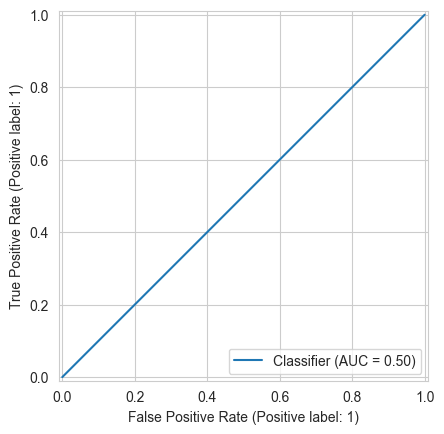

In [20]:
confusion_naive = confusion_matrix(Y_test, predictions_naive)
report_naive = classification_report(Y_test, predictions_naive)
accuracy_naive = accuracy_score(Y_test, predictions_naive)

print(f"Confusion Matrix:\n{confusion_naive}")
print(f"Accuracy: {accuracy_naive:.2f}")
print(f"Classification Report:\n{report_naive}")

ROCNaive = RocCurveDisplay.from_predictions(Y_test, predictions_naive)

# Part 3: Hyperparameter Tuning

### Technique 1: Gridsearch with 10 Fold Cross Validation

Warning: XGBoost and Randomforest Gridsearch could take a long time (for us 5-10 mins)

### Optimization of Classical Decision Tree

Fitting 10 folds for each of 840 candidates, totalling 8400 fits

Best Parameters:
                            Value
ccp_alpha                     0.0
class_weight                 None
criterion                 entropy
max_depth                    None
max_features                 None
max_leaf_nodes               None
min_impurity_decrease         0.0
min_samples_leaf                1
min_samples_split               2
min_weight_fraction_leaf      0.0
monotonic_cst                None
random_state                12345
splitter                     best

Performance on Test Set:
              Value
Accuracy   0.865000
Precision  0.825581
Recall     0.855422
F1 Score   0.840237
Confusion Matrix:
[[102  15]
 [ 12  71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       117
           1       0.83      0.86      0.84        83

    accuracy                           0.86       200
   macro avg       0.86      0.86

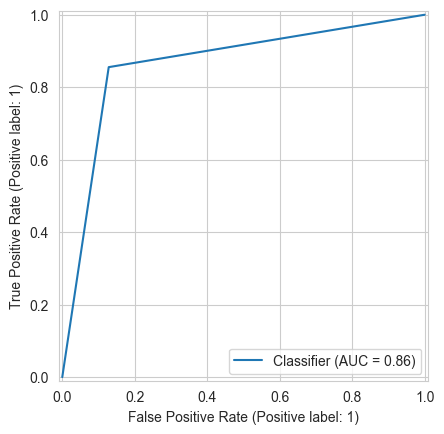

In [21]:
tree = DecisionTreeClassifier()
param_grid = {
    "criterion": ["entropy", "gini", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [None,10,20,50,100,250,500],
    "min_samples_leaf":[1,2,5,10,20],
    "min_samples_split": [2,3,4,5],
    "random_state":[12345]

}
scoring = "accuracy"

gridSearchedTree = GridSearchCV(
    tree,
    param_grid=param_grid,
    scoring=scoring,
    cv=10,
    refit=True,
    verbose = 1,
)

gridSearchedTree.fit(X_train, Y_train)

best_tree = gridSearchedTree.best_estimator_
best_params_tree = best_tree.get_params()
predictions_gridsearch_tree = best_tree.predict(X_test)


# Best Parameters Table
print("\nBest Parameters:")
params_df_tree = pd.DataFrame.from_dict(best_params_tree, orient='index', columns=['Value'])
print(params_df_tree.to_string())

confusion_gridsearch_tree = confusion_matrix(Y_test, predictions_gridsearch_tree)
report_gridsearch_tree = classification_report(Y_test, predictions_gridsearch_tree)
accuracy_gridsearch_tree = accuracy_score(Y_test, predictions_gridsearch_tree)

print("\nPerformance on Test Set:")
metrics_dict = {
    'Accuracy': accuracy_gridsearch_tree,
    'Precision': precision_score(Y_test, predictions_gridsearch_tree),
    'Recall': recall_score(Y_test, predictions_gridsearch_tree),
    'F1 Score': f1_score(Y_test, predictions_gridsearch_tree)
}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
print(metrics_df.to_string())


print(f"Confusion Matrix:\n{confusion_gridsearch_tree}")
print(f"Classification Report:\n{report_gridsearch_tree}")

ROCODT = RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_tree)

### Optimization of Random Forest

Fitting 10 folds for each of 96 candidates, totalling 960 fits

Best Parameters:
                            Value
bootstrap                    True
ccp_alpha                     0.0
class_weight                 None
criterion                 entropy
max_depth                    None
max_features                 sqrt
max_leaf_nodes               None
max_samples                  None
min_impurity_decrease         0.0
min_samples_leaf                1
min_samples_split               2
min_weight_fraction_leaf      0.0
monotonic_cst                None
n_estimators                  500
n_jobs                       None
oob_score                   False
random_state                12345
verbose                         0
warm_start                  False

Performance on Test Set:
              Value
Accuracy   0.900000
Precision  0.931507
Recall     0.819277
F1 Score   0.871795
Confusion Matrix:
[[112   5]
 [ 15  68]]
Classification Report:
              precision    recall  f1-score   sup

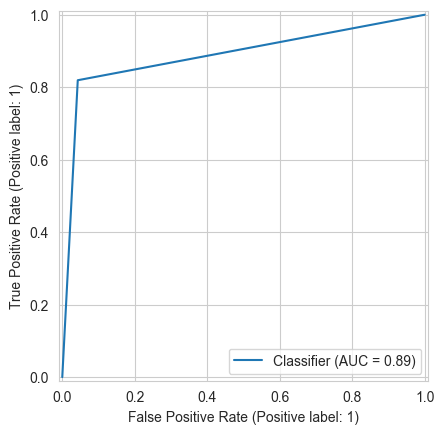

In [28]:
grid_forest = RandomForestClassifier()

param_grid_forest = {
    "criterion": ["entropy", "gini"],
    "n_estimators": [100,500,1000],
    "max_depth": [3,6,9,None],
    "min_samples_leaf":[1,2],
    "max_features": ["sqrt", "log2"],
    "random_state": [12345]
}
scoring = "accuracy"

gridSearchedForest = GridSearchCV(
    grid_forest,
    param_grid=param_grid_forest,
    scoring=scoring,
    cv=10,
    refit=True,
    verbose=1,
)


gridSearchedForest.fit(X_train, Y_train.to_numpy().ravel())

best_forest = gridSearchedForest.best_estimator_
best_params = best_forest.get_params()
predictions_gridsearch_forest = best_forest.predict(X_test)


# Best Parameters Table
print("\nBest Parameters:")
params_df = pd.DataFrame.from_dict(best_params, orient='index', columns=['Value'])
print(params_df.to_string())

confusion_gridsearch_forest = confusion_matrix(Y_test, predictions_gridsearch_forest)
report_gridsearch_forest = classification_report(Y_test, predictions_gridsearch_forest)
accuracy_gridsearch_forest = accuracy_score(Y_test, predictions_gridsearch_forest)
print("\nPerformance on Test Set:")
metrics_dict = {
    'Accuracy': accuracy_gridsearch_forest,
    'Precision': precision_score(Y_test, predictions_gridsearch_forest),
    'Recall': recall_score(Y_test, predictions_gridsearch_forest),
    'F1 Score': f1_score(Y_test, predictions_gridsearch_forest)
}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
print(metrics_df.to_string())


print(f"Confusion Matrix:\n{confusion_gridsearch_forest}")
print(f"Classification Report:\n{report_gridsearch_forest}")

ROCORF = RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_forest)

In [ ]:
default_params = best_forest.get_params()
print(default_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Hyperparameter Tuning for XGBoost

Fitting 10 folds for each of 432 candidates, totalling 4320 fits

Best Parameters:
                                   Value
objective                binary:logistic
base_score                          None
booster                             None
callbacks                           None
colsample_bylevel                   None
colsample_bynode                    None
colsample_bytree                     0.7
device                              None
early_stopping_rounds               None
enable_categorical                 False
eval_metric                         None
feature_types                       None
gamma                               None
grow_policy                         None
importance_type                     None
interaction_constraints             None
learning_rate                       None
max_bin                             None
max_cat_threshold                   None
max_cat_to_onehot                   None
max_delta_step                      None
max_depth      

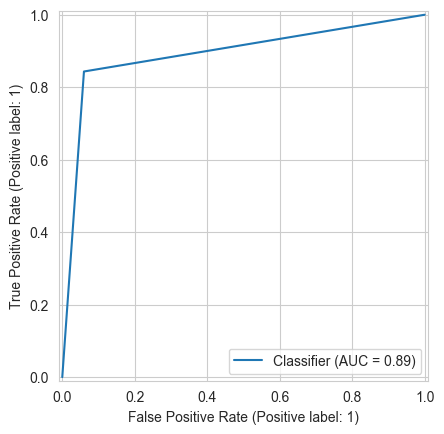

In [27]:
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

gridXG = xgboost.XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'eta': [0.05,0.1,0.2,0.3],
              'max_depth': [0, 3, 6, 9],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.7, 0.9, 1.0],
              'n_estimators': [100,500,1000],
              'seed': [12345]
}

scoring = "roc_auc"

gridSearchedXG = GridSearchCV(
    gridXG,
    param_grid=parameters,
    scoring=scoring,
    cv=10, # 10-Fold Cross Validation,
    refit = True,
    verbose=1
)



gridSearchedXG.fit(X_train, Y_train)

best_XG = gridSearchedXG.best_estimator_
best_params = best_XG.get_params()
predictions_gridsearch_XG = best_XG.predict(X_test)

# Best Parameters Table
print("\nBest Parameters:")
params_df = pd.DataFrame.from_dict(best_params, orient='index', columns=['Value'])
print(params_df.to_string())

confusion_gridsearch_XG = confusion_matrix(Y_test, predictions_gridsearch_XG)
report_gridsearch_XG = classification_report(Y_test, predictions_gridsearch_XG)
accuracy_gridsearch_XG = accuracy_score(Y_test, predictions_gridsearch_XG)

print("\nPerformance on Test Set:")
metrics_dict = {
    'Accuracy': accuracy_gridsearch_XG,
    'Precision': precision_score(Y_test, predictions_gridsearch_XG),
    'Recall': recall_score(Y_test, predictions_gridsearch_XG),
    'F1 Score': f1_score(Y_test, predictions_gridsearch_XG)
}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
print(metrics_df.to_string())

print(f"Confusion Matrix:\n{confusion_gridsearch_XG}")
print(f"Accuracy: {accuracy_gridsearch_XG}")
print(f"Classification Report:\n{report_gridsearch_XG}")

ROCOXGB = RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_XG)


### Logistic Regression Hyperparameter Tuning

c:\Users\nilga\Desktop\MESIO\Q2\Statistical Learning\Assigments\A1\statistical_learning_trees\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nilga\Desktop\MESIO\Q2\Statistical Learning\Assigments\A1\statistical_learning_trees\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nilga\Desktop\MESIO\Q2\Statistical Learning\Assigments\A1\statistical_learning_trees\venv\Lib\site-packages\sklearn\base.py", line 1389, in w


Best Parameters:
                   Value
C                    0.5
fit_intercept       True
max_iter             100
penalty               l1
solver         liblinear
verbose                0

Performance on Test Set:
              Value
Accuracy   0.855000
Precision  0.846154
Recall     0.795181
F1 Score   0.819876
Confusion Matrix:
[[105  12]
 [ 17  66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       117
           1       0.85      0.80      0.82        83

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



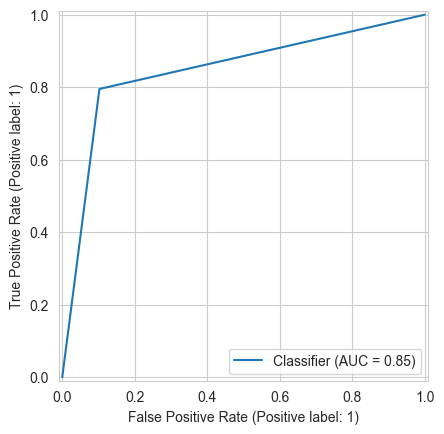

In [ ]:
logreg = LogisticRegression()
param_grid_logreg = {
    "penalty": ["l2", "l1", "elasticnet"],
    "C" : [0.5,1.0,1.5],
    "solver": ["liblinear", "newton-cholesky"],
    "max_iter": [100,200,300],
    "fit_intercept": [True, False],
    "verbose": [0]

}
scoring = "accuracy"

gridSearchedLogReg = GridSearchCV(
    logreg,
    param_grid=param_grid_logreg,
    scoring=scoring,
    cv=10,
    refit=True,
    verbose = 0
)

gridSearchedLogReg.fit(X_train, Y_train.to_numpy().ravel())

best_logreg = gridSearchedLogReg.best_estimator_
best_params_logreg = best_logreg.get_params()
predictions_gridsearch_logreg = best_logreg.predict(X_test)

# Best Parameters Table
print("\nBest Parameters:")
params_df_logreg = pd.DataFrame.from_dict(best_params_logreg, orient='index', columns=['Value'])
print(params_df_logreg.to_string())

confusion_gridsearch_logreg = confusion_matrix(Y_test, predictions_gridsearch_logreg)
report_gridsearch_logreg = classification_report(Y_test, predictions_gridsearch_logreg)
accuracy_gridsearch_logreg = accuracy_score(Y_test, predictions_gridsearch_logreg)

print("\nPerformance on Test Set:")
metrics_dict = {
    'Accuracy': accuracy_gridsearch_logreg,
    'Precision': precision_score(Y_test, predictions_gridsearch_logreg),
    'Recall': recall_score(Y_test, predictions_gridsearch_logreg),
    'F1 Score': f1_score(Y_test, predictions_gridsearch_logreg)
}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Value'])
print(metrics_df.to_string())

print(f"Confusion Matrix:\n{confusion_gridsearch_logreg}")
print(f"Classification Report:\n{report_gridsearch_logreg}")

ROCOLR =RocCurveDisplay.from_predictions(Y_test, predictions_gridsearch_logreg)

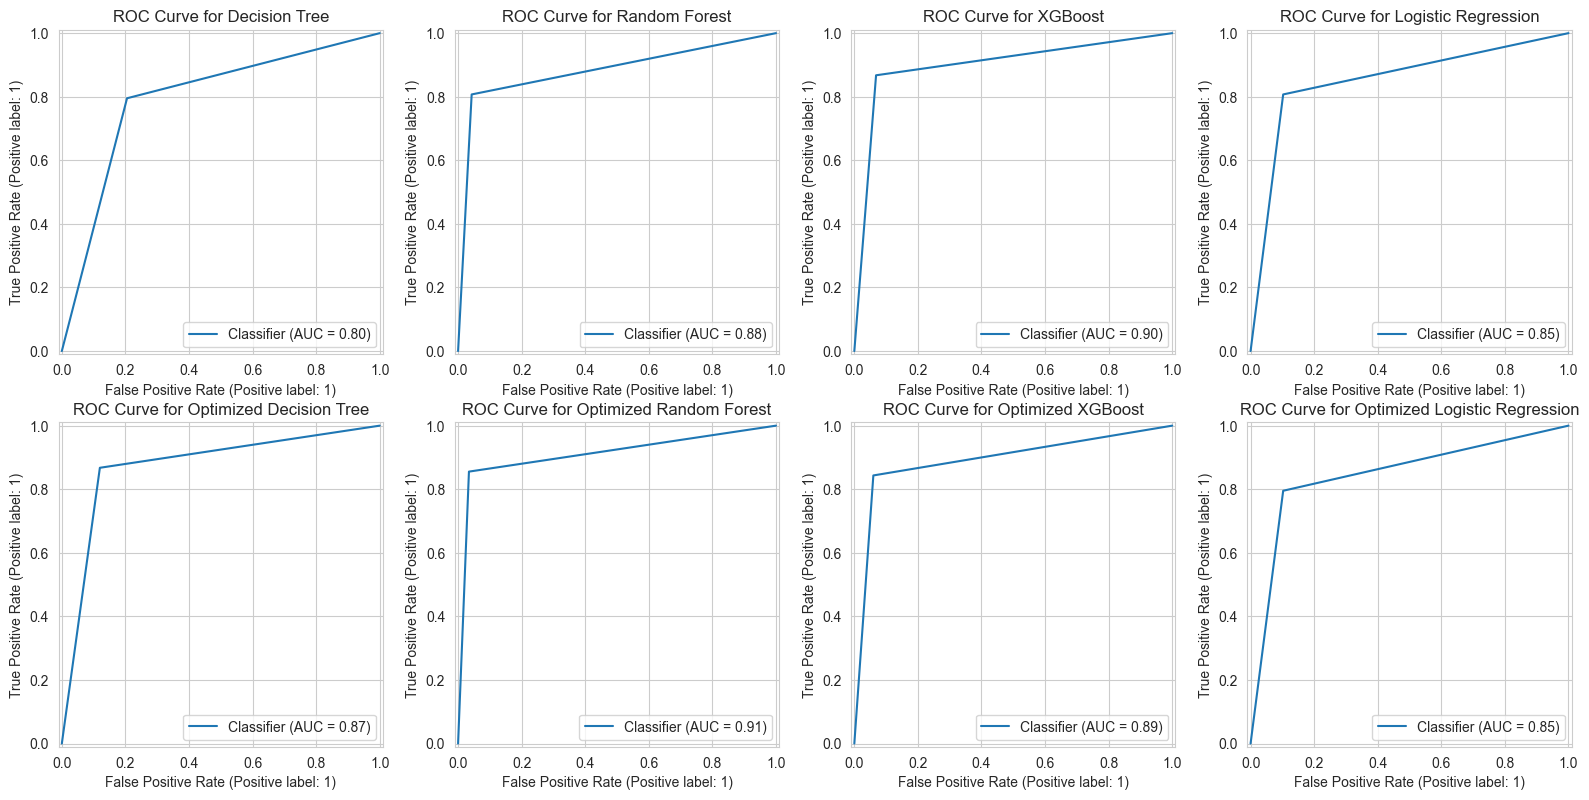

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
roc_displays = [ROCBDT, ROCBRF, ROCBXGB, ROCBLR, ROCODT, ROCORF, ROCOXGB, ROCOLR]
titles = [
    "ROC Curve for Decision Tree",
    "ROC Curve for Random Forest",
    "ROC Curve for XGBoost",
    "ROC Curve for Logistic Regression",
    "ROC Curve for Optimized Decision Tree",
    "ROC Curve for Optimized Random Forest",
    "ROC Curve for Optimized XGBoost",
    "ROC Curve for Optimized Logistic Regression"
]

for i, ax in enumerate(axes.flat):
    roc_displays[i].plot(ax=ax)
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

### To-Do: 
- Add Graphic at beginning that Shows weird negative numbers
- Remove negative numbers from Dataset before sampling the 600 for our Models
- Finish SVM Basic Model (Nico)
- Setup Latex (Nil)
- Standardize Output of Gridsearch (same as with XGBoost but for all: ... best parameters, etc.)

### Report Setup
- Description of the problem and dataset.
    - Problem: Binary Classification......
    - Dataset: rows, numbers, short description of distribution of variables, histograms, df.describe(), and how we sample the 600

- Explanation of the models and their parameters.
    - Short(Very Short) explanation of what each model is and does
    - Explanation of each parameter that we set

- Results and comparison of model performance.
    - Make a table of the most important performance metrics compared between all 4 models: accuracy, f1, precision, Confusion Matrix
    - Table for all finetunes ROC Curves,


- Conclusions on the best-performing model.
    - Probably Random Forest: Explain each parameter that is used in the final best model, feature importance
